In [27]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors #type: ignore
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [28]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

def make_tests(X, y):
    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y.ravel(),indices, train_size = 0.8, shuffle = True)
    return X_train, X_test, y_train, y_test, indices_train, indices_test
def model_score(model, X ,y):
    predicted = model.predict(X).reshape(-1, 1)
    blow_up_index = np.where(abs(predicted)>100)[0]
    normal = np.arange(len(y))[~np.isin(np.arange(len(y)), blow_up_index)]
    y = y[normal]
    predicted = predicted[normal]
    #print(np.max(np.abs(predicted - y)))
    r2 = r2_score(predicted, y)
    mse = mean_squared_error(predicted, y)
    return r2, mse
def cross_validate_model(X, y, model, n_splits=10):
    scores = []
    for i in range(n_splits):
        X_train, X_test, y_train, y_test, indices_train, indices_test = make_tests(X, y)
        trained_model = model.fit(X_train, y_train)
        scores.append(model_score(trained_model, X_test, y_test))
    return np.array(scores)

def summarize_scores(scores):
    mse_mean = np.mean(scores[:, 1])
    r2_mean = np.mean(scores[:, 0])
    mse_std = np.std(scores[:, 1]) / np.sqrt(len(scores))
    r2_std = np.std(scores[:, 0]) / np.sqrt(len(scores))
    return mse_mean, r2_mean, mse_std, r2_std

def getKeys(corr_thres):
    numeric_df = df_with_200_descriptors.dropna()

    corr_mat = numeric_df.corr().abs()
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > corr_thres)]

    # Drop highly correlated features
    final_df = numeric_df.drop(columns=to_drop)
    return final_df.keys()


In [4]:
full = pd.read_csv("../DataSets/Full_Free_Solv/full.csv", delimiter=";")
## Freesolv
#freesolv = pd.read_csv("../DataSets/Full_Free_Solv/full.csv")
full = full[["SoluteSMILES", "DeltaGsolv"]]
#freesolv['fp'] = freesolv['SoluteSMILES'].apply(lambda x: MAP4.calculate(Chem.MolFromSmiles(x)))
Mol_descriptors,desc_names = RDkit_descriptors(full['SoluteSMILES'])

[02:22:50] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/

In [5]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors = df_with_200_descriptors.loc[:, df_with_200_descriptors.std() != 0]
#df_with_200_descriptors

In [35]:
keys_75 = getKeys(0.75)

In [6]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Adding cannonical smiles for comparison..
combisolv['cannon_smiles'] = combisolv['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))
mnsoldf['cannon_smiles'] = mnsoldf['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))
freesoldf['cannon_smiles'] = freesoldf['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))


[02:22:56] WARNING: not removing hydrogen atom without neighbors


In [32]:
Mol_descriptors_mnsol,desc_names = RDkit_descriptors(mnsoldf['SoluteSMILES'])
Mol_descriptors_freesoldf,desc_names = RDkit_descriptors(freesoldf['SoluteSMILES'])
Mol_descriptors_combisoldf,desc_names = RDkit_descriptors(combisolv['SoluteSMILES'])

[02:50:55] WARNING: not removing hydrogen atom without neighbors
[02:50:55] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    re

In [33]:
def get_uncorr_dfs(keys):
    mnsol_df = pd.DataFrame(Mol_descriptors_mnsol,columns=desc_names)
    mnsol_df = mnsol_df[keys]

    freesol_df = pd.DataFrame(Mol_descriptors_freesoldf,columns=desc_names)
    freesol_df = freesol_df[keys]

    combisol_df = pd.DataFrame(Mol_descriptors_combisoldf,columns=desc_names)
    combisol_df = combisol_df[keys]
    return mnsol_df, freesol_df, combisol_df

In [36]:
mnsol_df75, freesol_df75, combisol_df75 = get_uncorr_dfs(keys_75)

In [37]:
all_data_desc = df_with_200_descriptors[keys_75]

In [38]:
scaler = MinMaxScaler()
scaled_ = scaler.fit_transform(all_data_desc)

In [39]:
# Create a UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(scaled_)

# Project mnsol_df75 and freesol_df75 onto the 2D reduced space
mnsol_2d = reducer.transform(scaler.transform(mnsol_df75))
freesol_2d = reducer.transform(scaler.transform(freesol_df75))
combisolv_2d = reducer.transform(scaler.transform(combisol_df75))

# Convert the results to DataFrames for easier handling
#mnsol_2d_df = pd.DataFrame(mnsol_2d, columns=['UMAP1', 'UMAP2'])
#freesol_2d_df = pd.DataFrame(freesol_2d, columns=['UMAP1', 'UMAP2'])

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

In [40]:
plt.style.use("/home/dm/Dibyendu/Projects/CVSampler/NoteBooks/style.txt")
plt.rcParams['font.family'] = "C059"

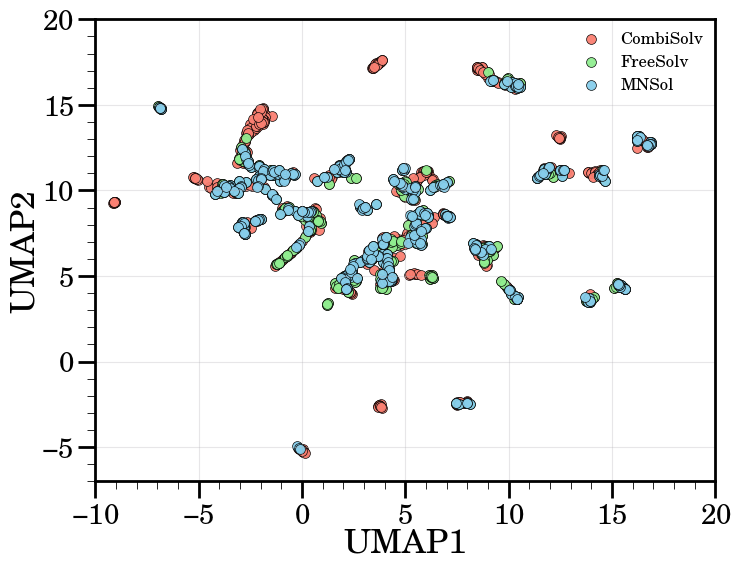

In [43]:
plt.figure(figsize=(8, 6))

# Scatter plots with different colors and labels
plt.scatter(combisolv_2d[:, 0], combisolv_2d[:, 1], c='salmon', label='CombiSolv',
            alpha=0.95, s=50,  edgecolor='black', lw = 0.5)
plt.scatter(freesol_2d[:, 0], freesol_2d[:, 1], label='FreeSolv', color='lightgreen',
            edgecolor='black', lw = 0.5, alpha=0.95, s=50)
plt.scatter(mnsol_2d[:, 0], mnsol_2d[:, 1], alpha=0.95, s=50, label='MNSol', color='skyblue',
            edgecolor='black', lw = 0.5)

# Add title and labels
plt.xlabel('UMAP1', fontsize=24)
plt.ylabel('UMAP2', fontsize=24)

# Add grid and legend
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(-10, 20)
plt.ylim(-7, 20)
# Show the plot
plt.show()

In [44]:
# Perform PCA projection
pca = PCA(n_components=2)
pca_projection = pca.fit_transform(scaled_)

mnsol_2d_pca = pca.transform(scaler.transform(mnsol_df75))
freesol_2d_pca = pca.transform(scaler.transform(freesol_df75))
combisolv_2d_pca = pca.transform(scaler.transform(combisol_df75))

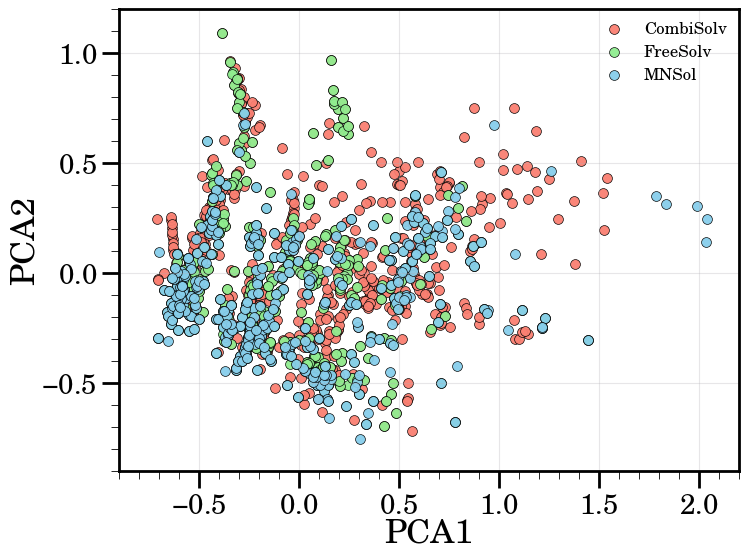

In [45]:
plt.figure(figsize=(8, 6))

# Scatter plots with different colors and labels
plt.scatter(combisolv_2d_pca[:, 0], combisolv_2d_pca[:, 1], c='salmon', label='CombiSolv',
            alpha=0.95, s=50,  edgecolor='black', lw = 0.5)
plt.scatter(freesol_2d_pca[:, 0], freesol_2d_pca[:, 1], label='FreeSolv', color='lightgreen',
            edgecolor='black', lw = 0.5, alpha=0.95, s=50)
plt.scatter(mnsol_2d_pca[:, 0], mnsol_2d_pca[:, 1], alpha=0.95, s=50, label='MNSol', color='skyblue',
            edgecolor='black', lw = 0.5)

# Add title and labels
plt.xlabel('PCA1', fontsize=24)
plt.ylabel('PCA2', fontsize=24)

# Add grid and legend
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(-0.9, 2.2)
plt.ylim(-0.9, 1.2)
# Show the plot
plt.show()

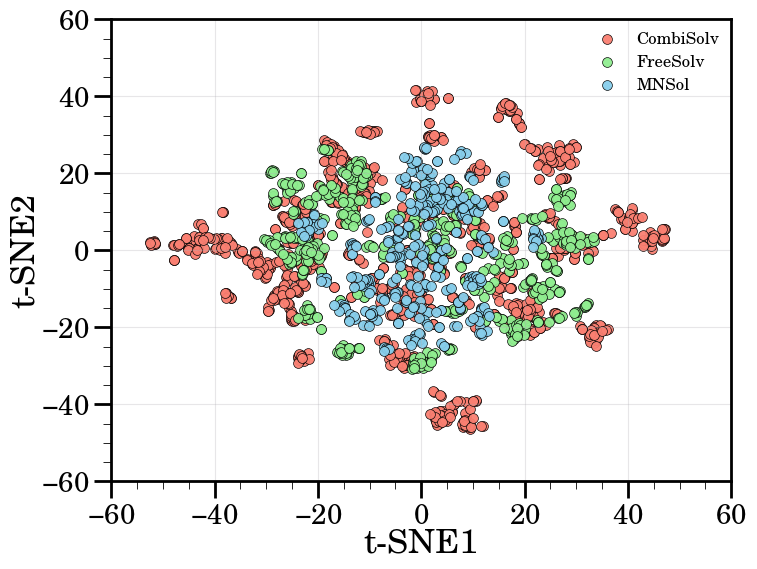

In [46]:
from sklearn.manifold import TSNE

# Perform t-SNE projection
tsne = TSNE(n_components=2, random_state=42)
tsne_projection = tsne.fit_transform(scaled_)

# Project mnsol_df75, freesol_df75, and combisol_df75 onto the 2D t-SNE space
mnsol_2d_tsne = tsne.fit_transform(scaler.transform(mnsol_df75))
freesol_2d_tsne = tsne.fit_transform(scaler.transform(freesol_df75))
combisolv_2d_tsne = tsne.fit_transform(scaler.transform(combisol_df75))

# Plot the t-SNE results
plt.figure(figsize=(8, 6))

# Scatter plots with different colors and labels
plt.scatter(combisolv_2d_tsne[:, 0], combisolv_2d_tsne[:, 1], c='salmon', label='CombiSolv',
            alpha=0.95, s=50, edgecolor='black', lw=0.5)
plt.scatter(freesol_2d_tsne[:, 0], freesol_2d_tsne[:, 1], label='FreeSolv', color='lightgreen',
            edgecolor='black', lw=0.5, alpha=0.95, s=50)
plt.scatter(mnsol_2d_tsne[:, 0], mnsol_2d_tsne[:, 1], alpha=0.95, s=50, label='MNSol', color='skyblue',
            edgecolor='black', lw=0.5)

# Add title and labels
plt.xlabel('t-SNE1', fontsize=24)
plt.ylabel('t-SNE2', fontsize=24)

# Add grid and legend
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

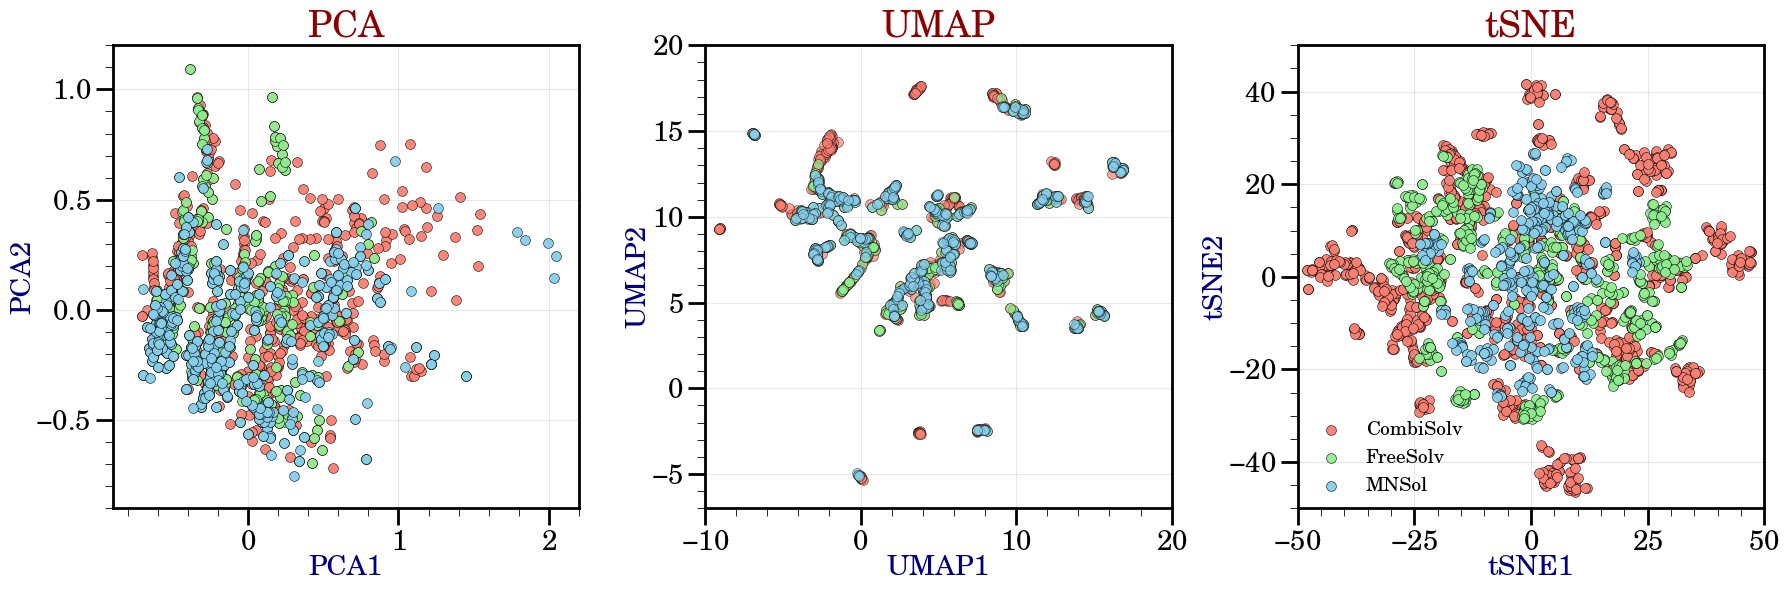

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(combisolv_2d_pca[:, 0], combisolv_2d_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(freesol_2d_pca[:, 0], freesol_2d_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_2d_pca[:, 0], mnsol_2d_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-0.9, 2.2)
axes[0].set_ylim(-0.9, 1.2)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(combisolv_2d[:, 0], combisolv_2d[:, 1], c='salmon', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(freesol_2d[:, 0], freesol_2d[:, 1], c='lightgreen', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(mnsol_2d[:, 0], mnsol_2d[:, 1], c='skyblue', alpha=0.7, edgecolor='black', s=50)
axes[1].set_xlim(-10, 20)
axes[1].set_ylim(-7, 20)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(combisolv_2d_tsne[:, 0], combisolv_2d_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(freesol_2d_tsne[:, 0], freesol_2d_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_2d_tsne[:, 0], mnsol_2d_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-50, 50)
axes[2].set_ylim(-50, 50)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "lower left", fontsize = 14)
plt.tight_layout()
#plt.savefig('desc_dimension.png', dpi = 120)
plt.show()

In [7]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import MACCSkeys

def generate_fingerprints(dim):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=1, fpSize=dim)
    ecfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=dim)
    rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=dim)
    apgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=dim)
    ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=dim)

    ## Fingerprint generation
    freesoldf['morganfp'] = freesoldf['mol'].apply(mfpgen.GetFingerprint)
    freesoldf['rdkgen'] = freesoldf['mol'].apply(rdkgen.GetFingerprint)
    freesoldf['apgen'] = freesoldf['mol'].apply(apgen.GetFingerprint)
    freesoldf['ttgen'] = freesoldf['mol'].apply(ttgen.GetFingerprint)
    freesoldf['ecfp'] = freesoldf['mol'].apply(ecfpgen.GetFingerprint)

    mnsoldf['morganfp'] = mnsoldf['mol'].apply(mfpgen.GetFingerprint)
    mnsoldf['rdkgen'] = mnsoldf['mol'].apply(rdkgen.GetFingerprint)
    mnsoldf['apgen'] = mnsoldf['mol'].apply(apgen.GetFingerprint)
    mnsoldf['ttgen'] = mnsoldf['mol'].apply(ttgen.GetFingerprint)
    mnsoldf['ecfp'] = mnsoldf['mol'].apply(ecfpgen.GetFingerprint)

    combisolv['ecfp'] = combisolv['mol'].apply(ecfpgen.GetFingerprint)
    combisolv['morganfp'] = combisolv['mol'].apply(mfpgen.GetFingerprint)
    combisolv['rdkgen'] = combisolv['mol'].apply(rdkgen.GetFingerprint)
    combisolv['apgen'] = combisolv['mol'].apply(apgen.GetFingerprint)
    combisolv['ttgen'] = combisolv['mol'].apply(ttgen.GetFingerprint)

    mnsol_morgan = np.vstack(mnsoldf['morganfp'].values)
    fsol_morgan = np.vstack(freesoldf['morganfp'].values)
    csol_morgan = np.vstack(combisolv['morganfp'].values)

    mnsol_ecfp = np.vstack(mnsoldf['ecfp'].values)
    fsol_ecfp = np.vstack(freesoldf['ecfp'].values)
    csol_ecfp = np.vstack(combisolv['ecfp'].values)

    # MAP4 keys
    #mnsol_map4 = joblib.load('mnsol_map4.pkl')
    mnsol_target = mnsoldf['DeltaGsolv'].values
    #csol_map4 = joblib.load('csol_map4.pkl')
    csol_target = combisolv['DeltaGsolv'].values
    #fsol_map4 = joblib.load('fsol_map4.pkl')
    fsol_target = freesoldf['DeltaGsolv'].values

    mnsol_tt = np.vstack(mnsoldf['ttgen'].values)
    fsol_tt = np.vstack(freesoldf['ttgen'].values)
    csol_tt = np.vstack(combisolv['ttgen'].values)

    mnsol_rdk = np.vstack(mnsoldf['rdkgen'].values)
    fsol_rdk = np.vstack(freesoldf['rdkgen'].values)
    csol_rdk = np.vstack(combisolv['rdkgen'].values)

    mnsol_ap = np.vstack(mnsoldf['apgen'].values)
    fsol_ap = np.vstack(freesoldf['apgen'].values)
    csol_ap = np.vstack(combisolv['apgen'].values)

    return {
        'mnsol_morgan': mnsol_morgan,
        'fsol_morgan': fsol_morgan,
        'csol_morgan': csol_morgan,
        'mnsol_ecfp': mnsol_ecfp,
        'fsol_ecfp': fsol_ecfp,
        'csol_ecfp': csol_ecfp,
        #'mnsol_map4': mnsol_map4,
        'mnsol_target': mnsol_target,
        #'csol_map4': csol_map4,
        'csol_target': csol_target,
        #'fsol_map4': fsol_map4,
        'fsol_target': fsol_target,
        'mnsol_tt': mnsol_tt,
        'fsol_tt': fsol_tt,
        'csol_tt': csol_tt,
        'mnsol_rdk': mnsol_rdk,
        'fsol_rdk': fsol_rdk,
        'csol_rdk': csol_rdk,
        'mnsol_ap': mnsol_ap,
        'fsol_ap': fsol_ap,
        'csol_ap': csol_ap
    }

In [8]:
## Smiles to Mol conversion
freesoldf['mol'] = freesoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
mnsoldf['mol'] = mnsoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
combisolv['mol'] = combisolv['SoluteSMILES'].apply(Chem.MolFromSmiles)

[02:23:05] WARNING: not removing hydrogen atom without neighbors


In [9]:
mnsol_pubchem = np.load('./Saved/pubchem_mnsol.npy')
fsol_pubchem = np.load('./Saved/pubchem_fsol.npy')
csol_pubchem = np.load('./Saved/pubchem_csol.npy')
mnsol_pubchem = mnsol_pubchem.reshape(-1, 881)
fsol_pubchem = fsol_pubchem.reshape(-1, 881)
csol_pubchem = csol_pubchem.reshape(-1, 881)

mnsol_maccs = []
for i in range(len(mnsoldf)):
    mnsol_maccs.append(list(MACCSkeys.GenMACCSKeys(mnsoldf['mol'][i])))

fsol_maccs = []
for i in range(len(freesoldf)):
    fsol_maccs.append(list(MACCSkeys.GenMACCSKeys(freesoldf['mol'][i])))

csol_maccs = []
for i in range(len(combisolv)):
    csol_maccs.append(list(MACCSkeys.GenMACCSKeys(combisolv['mol'].iloc[i])))

mnsol_maccs = np.array(mnsol_maccs)
fsol_maccs = np.array(fsol_maccs)
csol_maccs = np.array(csol_maccs)

In [14]:
common_freesol = np.loadtxt("./freesolv_comm.txt").astype(int)
common_mnsol = np.loadtxt("./mnsol_comm.txt").astype(int)

In [18]:
full_pubchem = np.concatenate([mnsol_pubchem[common_mnsol], fsol_pubchem[common_freesol], csol_pubchem])
full_maccs = np.concatenate([mnsol_maccs[common_mnsol], fsol_maccs[common_freesol], csol_maccs])

In [ ]:
results_2048 = generate_fingerprints(2048)
csol_target = combisolv['DeltaGsolv'].values
fsol_target = freesoldf['DeltaGsolv'].values
mnsol_target = mnsoldf['DeltaGsolv'].values

In [60]:
full_ap = np.concatenate([results_2048['mnsol_ap'][common_mnsol], results_2048['fsol_ap'][common_freesol], results_2048['csol_ap']])
full_rdk = np.concatenate([results_2048['mnsol_rdk'][common_mnsol], results_2048['fsol_rdk'][common_freesol], results_2048['csol_rdk']])
full_morgan = np.concatenate([results_2048['mnsol_morgan'][common_mnsol], results_2048['fsol_morgan'][common_freesol], results_2048['csol_morgan']])
full_ecfp = np.concatenate([results_2048['mnsol_ecfp'][common_mnsol], results_2048['fsol_ecfp'][common_freesol], results_2048['csol_ecfp']])

In [ ]:
mnsol_ap = results_2048['mnsol_ap']

In [25]:
full_target = full['DeltaGsolv'].values

In [56]:
# Perform PCA projection on full_maccs
pca_full_maccs = PCA(n_components=2)
pca_full_maccs_projection = pca_full_maccs.fit_transform(full_maccs)

# Project individual datasets
mnsol_maccs_pca = pca_full_maccs.transform(mnsol_maccs)
fsol_maccs_pca = pca_full_maccs.transform(fsol_maccs)
csol_maccs_pca = pca_full_maccs.transform(csol_maccs)

# Perform t-SNE projection on full_maccs
tsne_full_maccs = TSNE(n_components=2, random_state=42)
tsne_full_maccs_projection = tsne_full_maccs.fit_transform(full_maccs)

# Project individual datasets
mnsol_maccs_tsne = tsne_full_maccs.fit_transform(mnsol_maccs)
fsol_maccs_tsne = tsne_full_maccs.fit_transform(fsol_maccs)
csol_maccs_tsne = tsne_full_maccs.fit_transform(csol_maccs)

reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(full_maccs)
# Perform UMAP projection on mnsol_pubchem

# Project individual datasets
mnsol_maccs_umap = reducer.transform(mnsol_maccs)
fsol_maccs_umap = reducer.transform(fsol_maccs)
csol_maccs_umap = reducer.transform(csol_maccs)

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

In [57]:
# Perform PCA projection on full_pubchem
pca_full_pubchem = PCA(n_components=2)
pca_full_pubchem_projection = pca_full_pubchem.fit_transform(full_pubchem)

# Project individual datasets
mnsol_pubchem_pca = pca_full_pubchem.transform(mnsol_pubchem)
fsol_pubchem_pca = pca_full_pubchem.transform(fsol_pubchem)
csol_pubchem_pca = pca_full_pubchem.transform(csol_pubchem)

# Perform t-SNE projection on full_pubchem
tsne_full_pubchem = TSNE(n_components=2, random_state=42)
tsne_full_pubchem_projection = tsne_full_pubchem.fit_transform(full_pubchem)

# Project individual datasets
mnsol_pubchem_tsne = tsne_full_pubchem.fit_transform(mnsol_pubchem)
fsol_pubchem_tsne = tsne_full_pubchem.fit_transform(fsol_pubchem)
csol_pubchem_tsne = tsne_full_pubchem.fit_transform(csol_pubchem)

reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(full_pubchem)
# Perform UMAP projection on mnsol_pubchem

# Project individual datasets
mnsol_pubchem_umap = reducer.transform(mnsol_pubchem)
fsol_pubchem_umap = reducer.transform(fsol_pubchem)
csol_pubchem_umap = reducer.transform(csol_pubchem)

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

In [58]:
# Perform PCA projection on full_ap
pca_full_ap = PCA(n_components=2)
pca_full_ap_projection = pca_full_ap.fit_transform(full_ap)

# Project individual datasets
mnsol_ap_pca = pca_full_ap.transform(results_2048['mnsol_ap'])
fsol_ap_pca = pca_full_ap.transform(results_2048['fsol_ap'])
csol_ap_pca = pca_full_ap.transform(results_2048['csol_ap'])

# Perform t-SNE projection on full_ap
tsne_full_ap = TSNE(n_components=2, random_state=42)
tsne_full_ap_projection = tsne_full_ap.fit_transform(full_ap)

# Project individual datasets
mnsol_ap_tsne = tsne_full_ap.fit_transform(results_2048['mnsol_ap'])
fsol_ap_tsne = tsne_full_ap.fit_transform(results_2048['fsol_ap'])
csol_ap_tsne = tsne_full_ap.fit_transform(results_2048['csol_ap'])

reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(full_ap)
# Perform UMAP projection on mnsol_ap

# Project individual datasets
mnsol_ap_umap = reducer.transform(results_2048['mnsol_ap'])
fsol_ap_umap = reducer.transform(results_2048['fsol_ap'])
csol_ap_umap = reducer.transform(results_2048['csol_ap'])

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

In [65]:
# Perform PCA projection on full_rdk
pca_full_rdk = PCA(n_components=2)
pca_full_rdk_projection = pca_full_rdk.fit_transform(full_rdk)

# Project individual datasets
mnsol_rdk_pca = pca_full_rdk.transform(results_2048['mnsol_rdk'])
fsol_rdk_pca = pca_full_rdk.transform(results_2048['fsol_rdk'])
csol_rdk_pca = pca_full_rdk.transform(results_2048['csol_rdk'])

# Perform t-SNE projection on full_rdk
tsne_full_rdk = TSNE(n_components=2, random_state=42)
tsne_full_rdk_projection = tsne_full_rdk.fit_transform(full_rdk)

# Project individual datasets
mnsol_rdk_tsne = tsne_full_rdk.fit_transform(results_2048['mnsol_rdk'])
fsol_rdk_tsne = tsne_full_rdk.fit_transform(results_2048['fsol_rdk'])
csol_rdk_tsne = tsne_full_rdk.fit_transform(results_2048['csol_rdk'])

reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(full_rdk)
# Perform UMrdk projection on mnsol_rdk

# Project individual datasets
mnsol_rdk_umap = reducer.transform(results_2048['mnsol_rdk'])
fsol_rdk_umap = reducer.transform(results_2048['fsol_rdk'])
csol_rdk_umap = reducer.transform(results_2048['csol_rdk'])

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

In [66]:
# Perform PCA projection on full_morgan
pca_full_morgan = PCA(n_components=2)
pca_full_morgan_projection = pca_full_morgan.fit_transform(full_morgan)

# Project individual datasets
mnsol_morgan_pca = pca_full_morgan.transform(results_2048['mnsol_morgan'])
fsol_morgan_pca = pca_full_morgan.transform(results_2048['fsol_morgan'])
csol_morgan_pca = pca_full_morgan.transform(results_2048['csol_morgan'])

# Perform t-SNE projection on full_morgan
tsne_full_morgan = TSNE(n_components=2, random_state=42)
tsne_full_morgan_projection = tsne_full_morgan.fit_transform(full_morgan)

# Project individual datasets
mnsol_morgan_tsne = tsne_full_morgan.fit_transform(results_2048['mnsol_morgan'])
fsol_morgan_tsne = tsne_full_morgan.fit_transform(results_2048['fsol_morgan'])
csol_morgan_tsne = tsne_full_morgan.fit_transform(results_2048['csol_morgan'])

reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(full_morgan)
# Perform UMmorgan projection on mnsol_morgan

# Project individual datasets
mnsol_morgan_umap = reducer.transform(results_2048['mnsol_morgan'])
fsol_morgan_umap = reducer.transform(results_2048['fsol_morgan'])
csol_morgan_umap = reducer.transform(results_2048['csol_morgan'])

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

In [68]:
# Perform PCA projection on full_ecfp
pca_full_ecfp = PCA(n_components=2)
pca_full_ecfp_projection = pca_full_ecfp.fit_transform(full_ecfp)

# Project individual datasets
mnsol_ecfp_pca = pca_full_ecfp.transform(results_2048['mnsol_ecfp'])
fsol_ecfp_pca = pca_full_ecfp.transform(results_2048['fsol_ecfp'])
csol_ecfp_pca = pca_full_ecfp.transform(results_2048['csol_ecfp'])

# Perform t-SNE projection on full_ecfp
tsne_full_ecfp = TSNE(n_components=2, random_state=42)
tsne_full_ecfp_projection = tsne_full_ecfp.fit_transform(full_ecfp)

# Project individual datasets
mnsol_ecfp_tsne = tsne_full_ecfp.fit_transform(results_2048['mnsol_ecfp'])
fsol_ecfp_tsne = tsne_full_ecfp.fit_transform(results_2048['fsol_ecfp'])
csol_ecfp_tsne = tsne_full_ecfp.fit_transform(results_2048['csol_ecfp'])

reducer = umap.UMAP(n_components=2, random_state=42)
reducer.fit(full_ecfp)
# Perform UMap projection on mnsol_ecfp

# Project individual datasets
mnsol_ecfp_umap = reducer.transform(results_2048['mnsol_ecfp'])
fsol_ecfp_umap = reducer.transform(results_2048['fsol_ecfp'])
csol_ecfp_umap = reducer.transform(results_2048['csol_ecfp'])

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

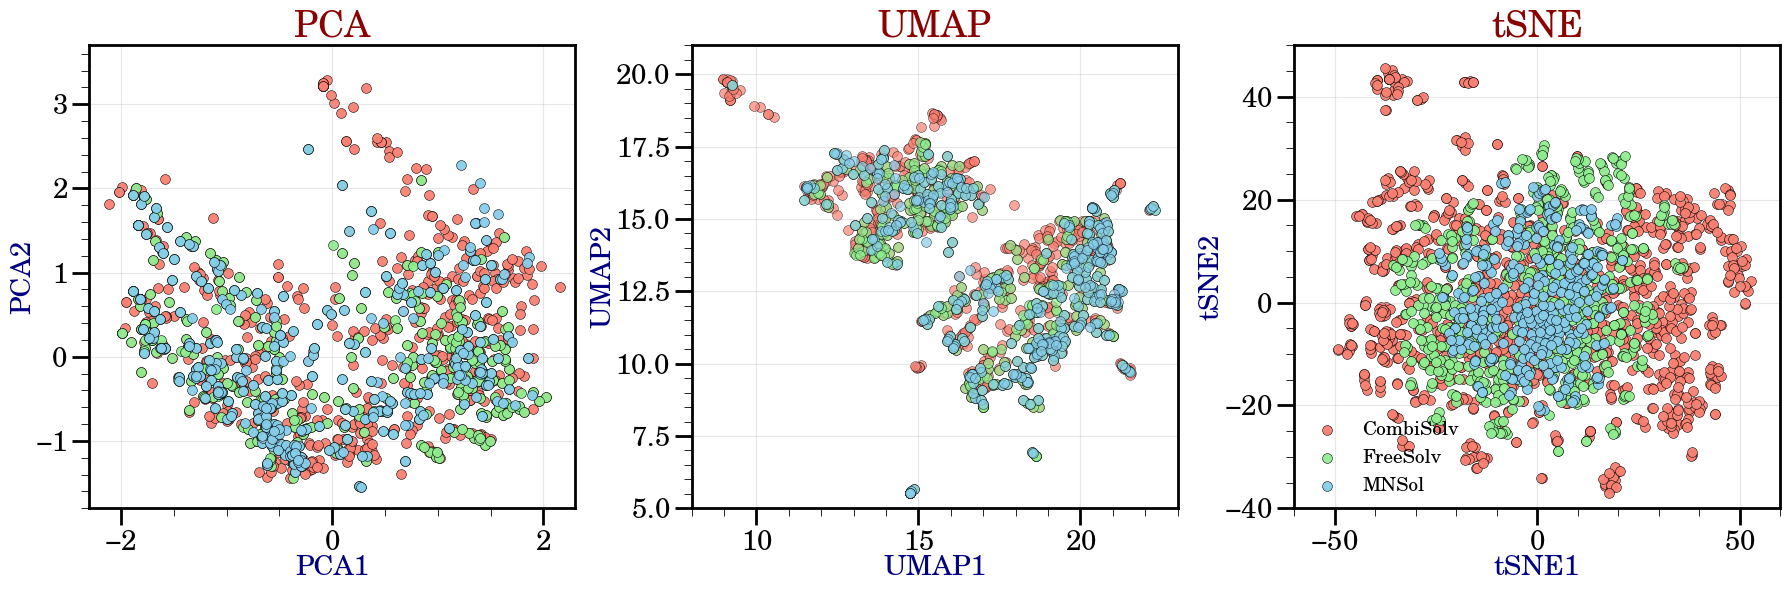

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(csol_ecfp_pca[:, 0], csol_ecfp_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(fsol_ecfp_pca[:, 0], fsol_ecfp_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_ecfp_pca[:, 0], mnsol_ecfp_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-2.3, 2.3)
axes[0].set_ylim(-1.8, 3.7)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(csol_ecfp_umap[:, 0], csol_ecfp_umap[:, 1], c='salmon', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(fsol_ecfp_umap[:, 0], fsol_ecfp_umap[:, 1], c='lightgreen', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(mnsol_ecfp_umap[:, 0], mnsol_ecfp_umap[:, 1], c='skyblue', alpha=0.7, edgecolor='black', s=50)
axes[1].set_xlim(8, 23)
axes[1].set_ylim(5, 21)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(csol_ecfp_tsne[:, 0], csol_ecfp_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(fsol_ecfp_tsne[:, 0], fsol_ecfp_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_ecfp_tsne[:, 0], mnsol_ecfp_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-60, 60)
axes[2].set_ylim(-40, 50)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "lower left", fontsize = 14)
plt.tight_layout()
plt.savefig('ecfp_fp_dimension.png', dpi = 120)
plt.show()

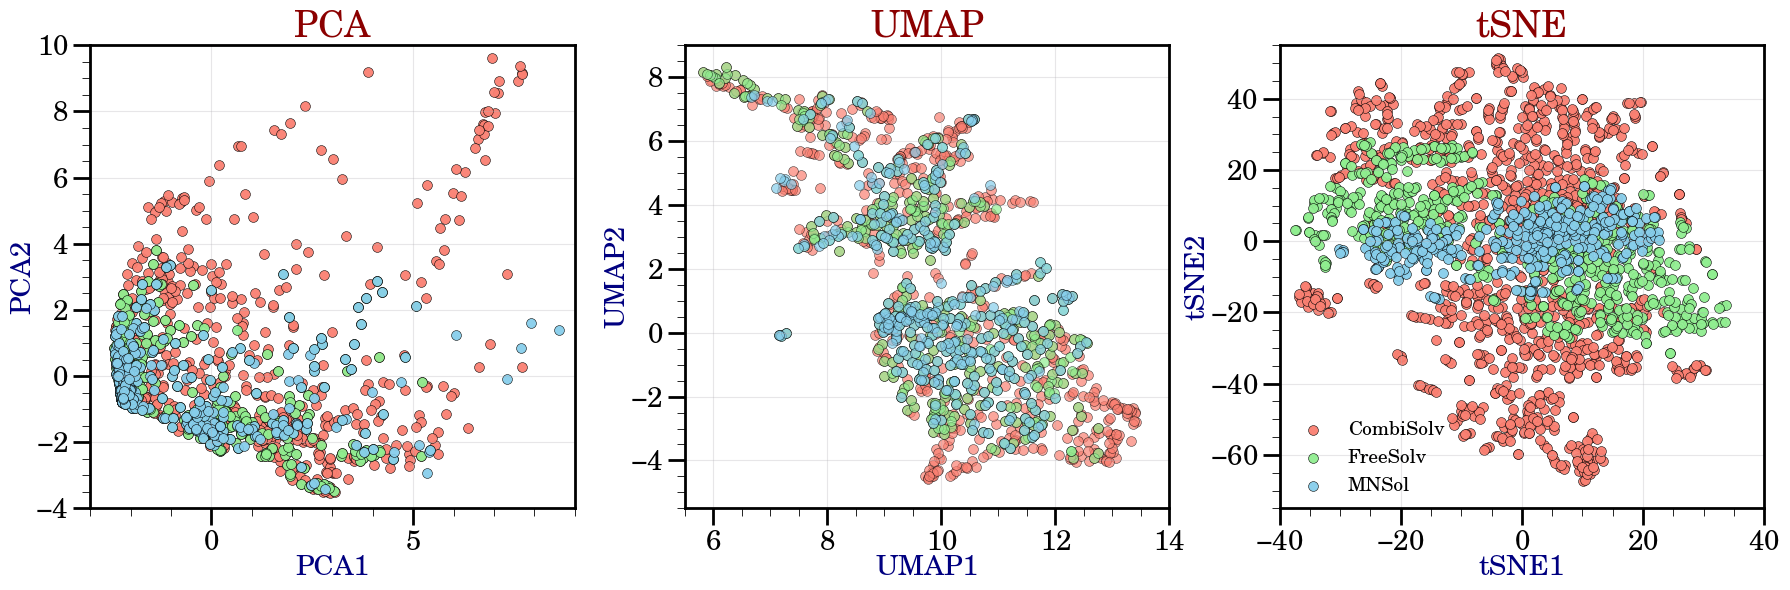

In [189]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(csol_ap_pca[:, 0], csol_ap_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(fsol_ap_pca[:, 0], fsol_ap_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_ap_pca[:, 0], mnsol_ap_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-3, 9)
axes[0].set_ylim(-4, 10)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(csol_ap_umap[:, 0], csol_ap_umap[:, 1], c='salmon', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(fsol_ap_umap[:, 0], fsol_ap_umap[:, 1], c='lightgreen', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(mnsol_ap_umap[:, 0], mnsol_ap_umap[:, 1], c='skyblue', alpha=0.7, edgecolor='black', s=50)
axes[1].set_xlim(5.5, 14)
axes[1].set_ylim(-5.5, 9.0)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(csol_ap_tsne[:, 0], csol_ap_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(fsol_ap_tsne[:, 0], fsol_ap_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_ap_tsne[:, 0], mnsol_ap_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-40, 40)
axes[2].set_ylim(-75, 55)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "lower left", fontsize = 14)
plt.tight_layout()
plt.savefig('ap_fp_dimension.png', dpi = 120)
plt.show()

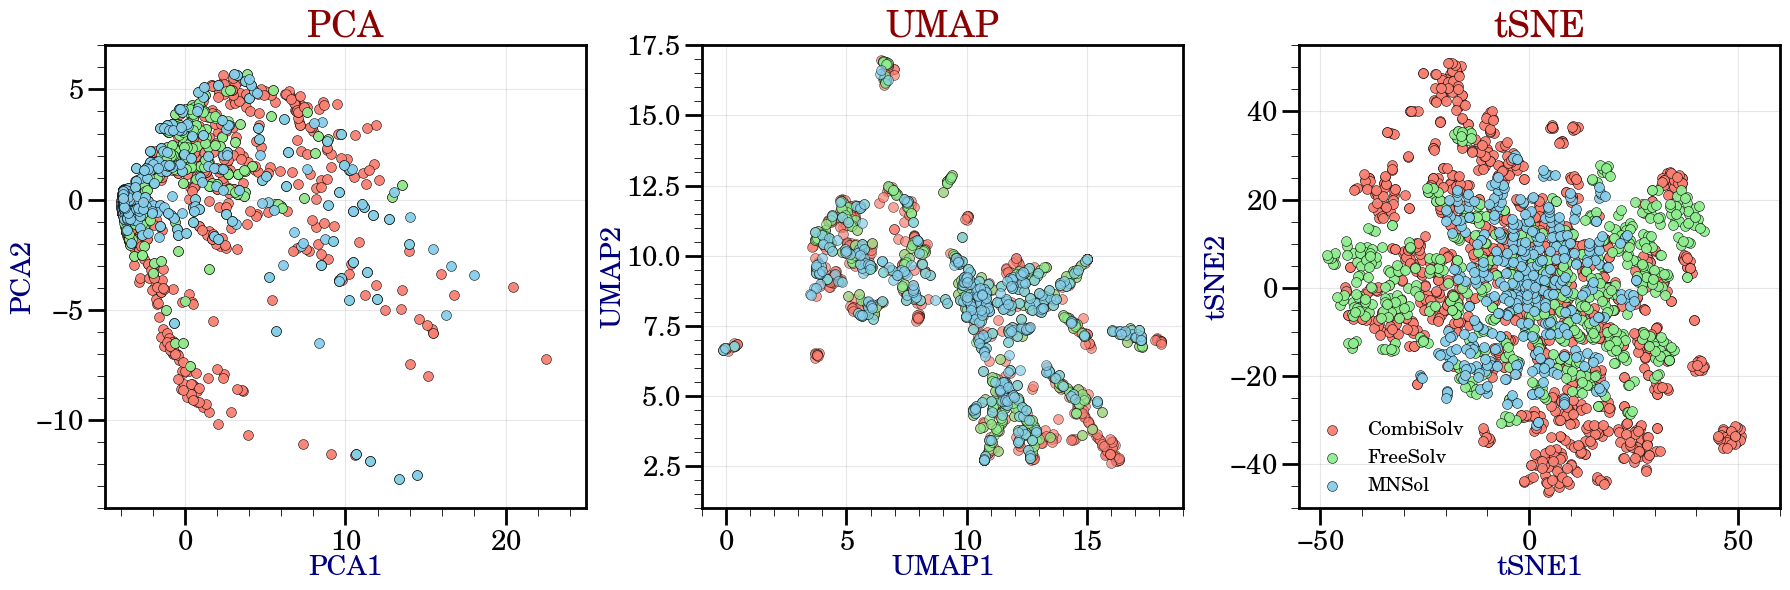

In [191]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(csol_rdk_pca[:, 0], csol_rdk_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(fsol_rdk_pca[:, 0], fsol_rdk_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_rdk_pca[:, 0], mnsol_rdk_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-5, 25)
axes[0].set_ylim(-14, 7)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(csol_rdk_umap[:, 0], csol_rdk_umap[:, 1], c='salmon', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(fsol_rdk_umap[:, 0], fsol_rdk_umap[:, 1], c='lightgreen', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(mnsol_rdk_umap[:, 0], mnsol_rdk_umap[:, 1], c='skyblue', alpha=0.7, edgecolor='black', s=50)
axes[1].set_xlim(-1, 19)
axes[1].set_ylim(1, 17.5)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(csol_rdk_tsne[:, 0], csol_rdk_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(fsol_rdk_tsne[:, 0], fsol_rdk_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_rdk_tsne[:, 0], mnsol_rdk_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-55, 60)
axes[2].set_ylim(-50, 55)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "lower left", fontsize = 14)
plt.tight_layout()
plt.savefig('rdk_fp_dimension.png', dpi = 120)
plt.show()

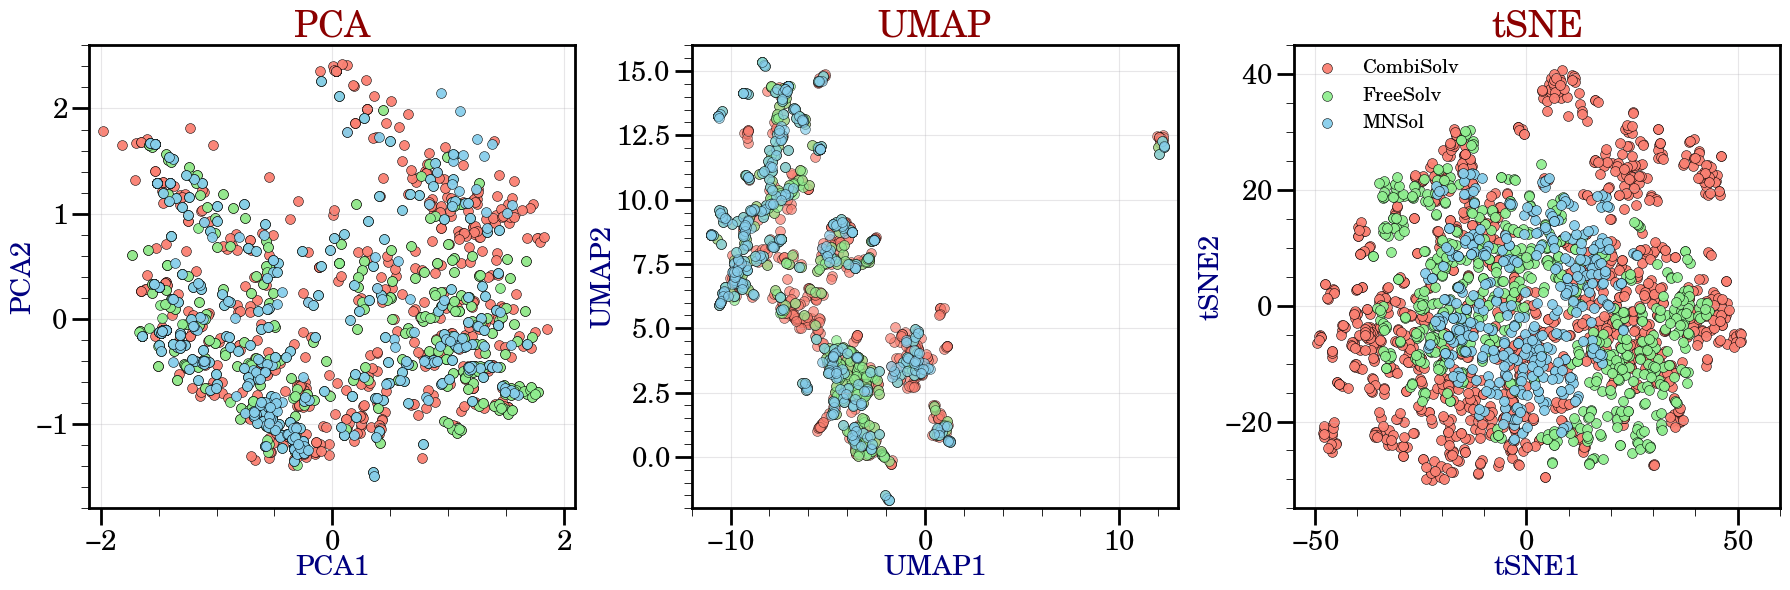

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(csol_morgan_pca[:, 0], csol_morgan_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(fsol_morgan_pca[:, 0], fsol_morgan_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_morgan_pca[:, 0], mnsol_morgan_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-2.1, 2.1)
axes[0].set_ylim(-1.8, 2.6)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(csol_morgan_umap[:, 0], csol_morgan_umap[:, 1], c='salmon', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(fsol_morgan_umap[:, 0], fsol_morgan_umap[:, 1], c='lightgreen', alpha=0.7, edgecolor='black', s=50)
axes[1].scatter(mnsol_morgan_umap[:, 0], mnsol_morgan_umap[:, 1], c='skyblue', alpha=0.7, edgecolor='black', s=50)
axes[1].set_xlim(-12, 13)
axes[1].set_ylim(-2, 16)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(csol_morgan_tsne[:, 0], csol_morgan_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(fsol_morgan_tsne[:, 0], fsol_morgan_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_morgan_tsne[:, 0], mnsol_morgan_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-55, 60)
axes[2].set_ylim(-35, 45)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "upper left", fontsize = 14)
plt.tight_layout()
plt.savefig('morgan_fp_dimension.png', dpi = 120)
plt.show()

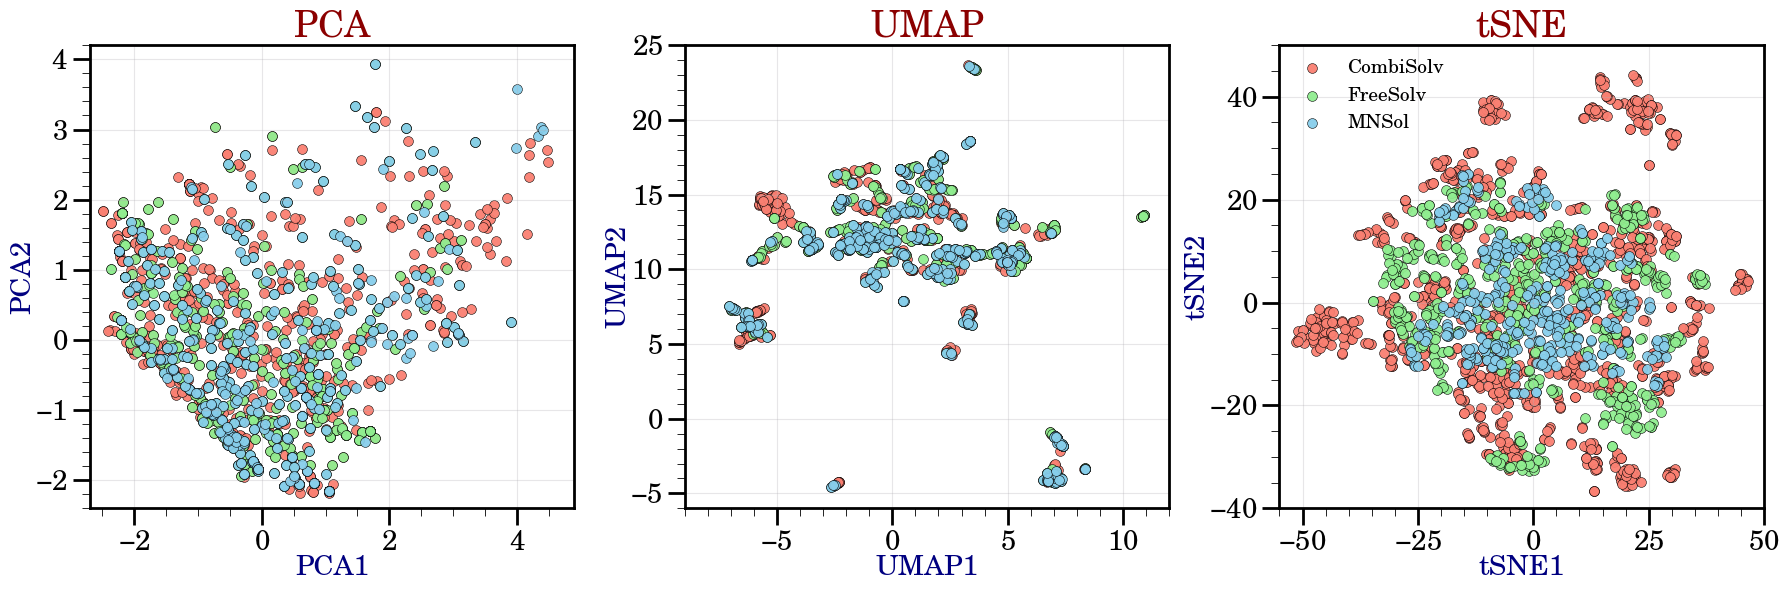

In [193]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(csol_maccs_pca[:, 0], csol_maccs_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(fsol_maccs_pca[:, 0], fsol_maccs_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_maccs_pca[:, 0], mnsol_maccs_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-2.7, 4.9)
axes[0].set_ylim(-2.4, 4.2)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(csol_maccs_umap[:, 0], csol_maccs_umap[:, 1], c='salmon', alpha=0.95, edgecolor='black', s=50)
axes[1].scatter(fsol_maccs_umap[:, 0], fsol_maccs_umap[:, 1], c='lightgreen', alpha=0.95, edgecolor='black', s=50)
axes[1].scatter(mnsol_maccs_umap[:, 0], mnsol_maccs_umap[:, 1], c='skyblue', alpha=0.95, edgecolor='black', s=50)
axes[1].set_xlim(-9, 12)
axes[1].set_ylim(-6, 25)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(csol_maccs_tsne[:, 0], csol_maccs_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(fsol_maccs_tsne[:, 0], fsol_maccs_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_maccs_tsne[:, 0], mnsol_maccs_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-55, 50)
axes[2].set_ylim(-40, 50)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "upper left", fontsize = 14)
plt.tight_layout()
plt.savefig('maccs_fp_dimension.png', dpi = 120)
plt.show()

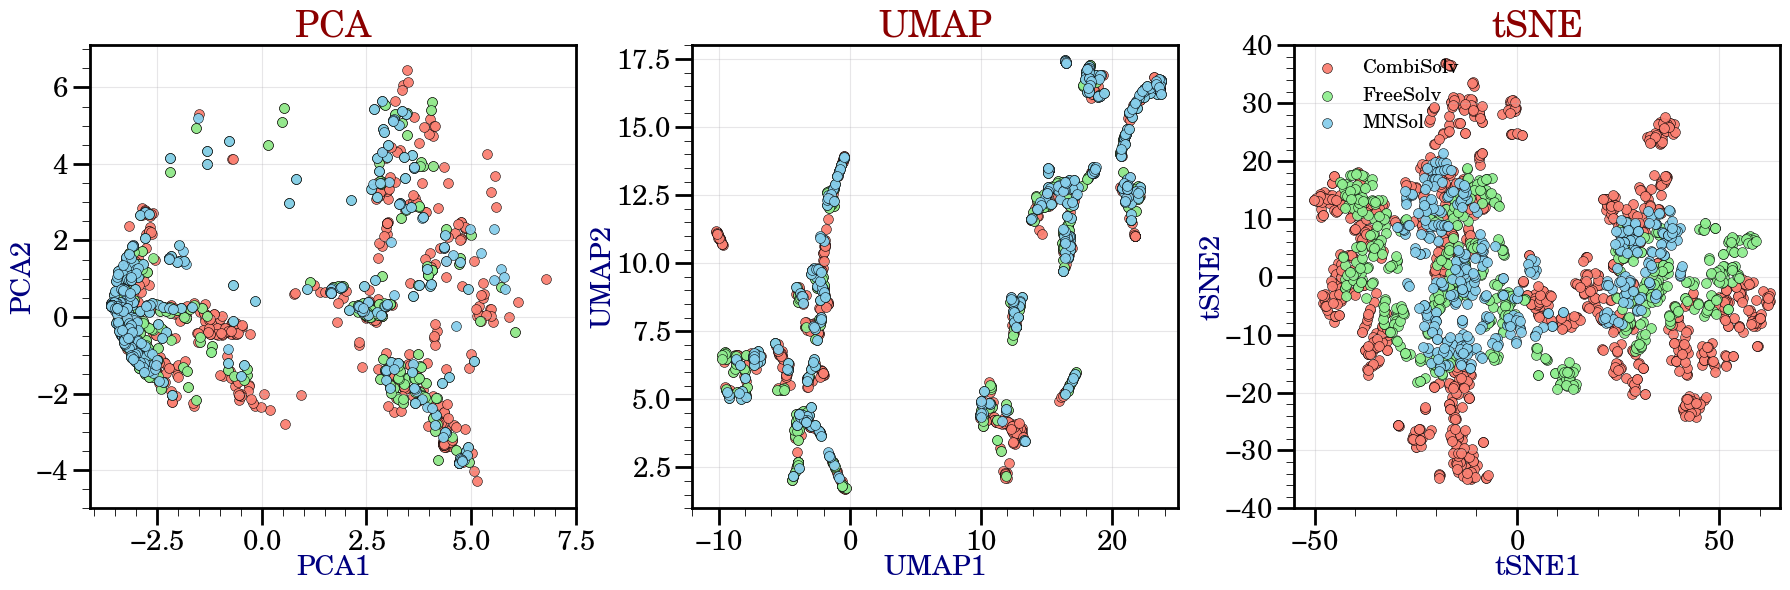

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#PCA plot
axes[0].scatter(csol_pubchem_pca[:, 0], csol_pubchem_pca[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(fsol_pubchem_pca[:, 0], fsol_pubchem_pca[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50)
axes[0].scatter(mnsol_pubchem_pca[:, 0], mnsol_pubchem_pca[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50)
axes[0].set_xlim(-4.1, 7.5)
axes[0].set_ylim(-5.0, 7.1)
axes[0].set_title('PCA', fontsize=26, loc = "center", color = "darkred")
axes[0].set_xlabel('PCA1', fontsize=20, color = "navy")
axes[0].set_ylabel('PCA2', fontsize=20, color = "navy")
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(csol_pubchem_umap[:, 0], csol_pubchem_umap[:, 1], c='salmon', alpha=0.95, edgecolor='black', s=50)
axes[1].scatter(fsol_pubchem_umap[:, 0], fsol_pubchem_umap[:, 1], c='lightgreen', alpha=0.95, edgecolor='black', s=50)
axes[1].scatter(mnsol_pubchem_umap[:, 0], mnsol_pubchem_umap[:, 1], c='skyblue', alpha=0.95, edgecolor='black', s=50)
axes[1].set_xlim(-12, 25)
axes[1].set_ylim(1, 18)
axes[1].set_title('UMAP', fontsize=26, loc = "center", color = "darkred")
axes[1].set_xlabel('UMAP1', fontsize=20, color = "navy")
axes[1].set_ylabel('UMAP2', fontsize=20, color = "navy")
axes[1].grid(alpha=0.3)

# t-SNE plot
axes[2].scatter(csol_pubchem_tsne[:, 0], csol_pubchem_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label = "CombiSolv")
axes[2].scatter(fsol_pubchem_tsne[:, 0], fsol_pubchem_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label = "FreeSolv")
axes[2].scatter(mnsol_pubchem_tsne[:, 0], mnsol_pubchem_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label = "MNSol")
axes[2].set_xlim(-55, 65)
axes[2].set_ylim(-40, 40)
axes[2].set_title('tSNE', fontsize=26, loc = "center", color = "darkred")
axes[2].set_xlabel('tSNE1', fontsize=20, color = "navy")
axes[2].set_ylabel('tSNE2', fontsize=20, color = "navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc = "upper left", fontsize = 14)
plt.tight_layout()
plt.savefig('pubchem_fp_dimension.png', dpi = 120)
plt.show()

In [195]:
mnsol_gncvae = np.load('mnsol_gncvae.npy')
fsol_gncvae = np.load('fsol_gncvae.npy')
csol_gncvae = np.load('csol_gncvae.npy')

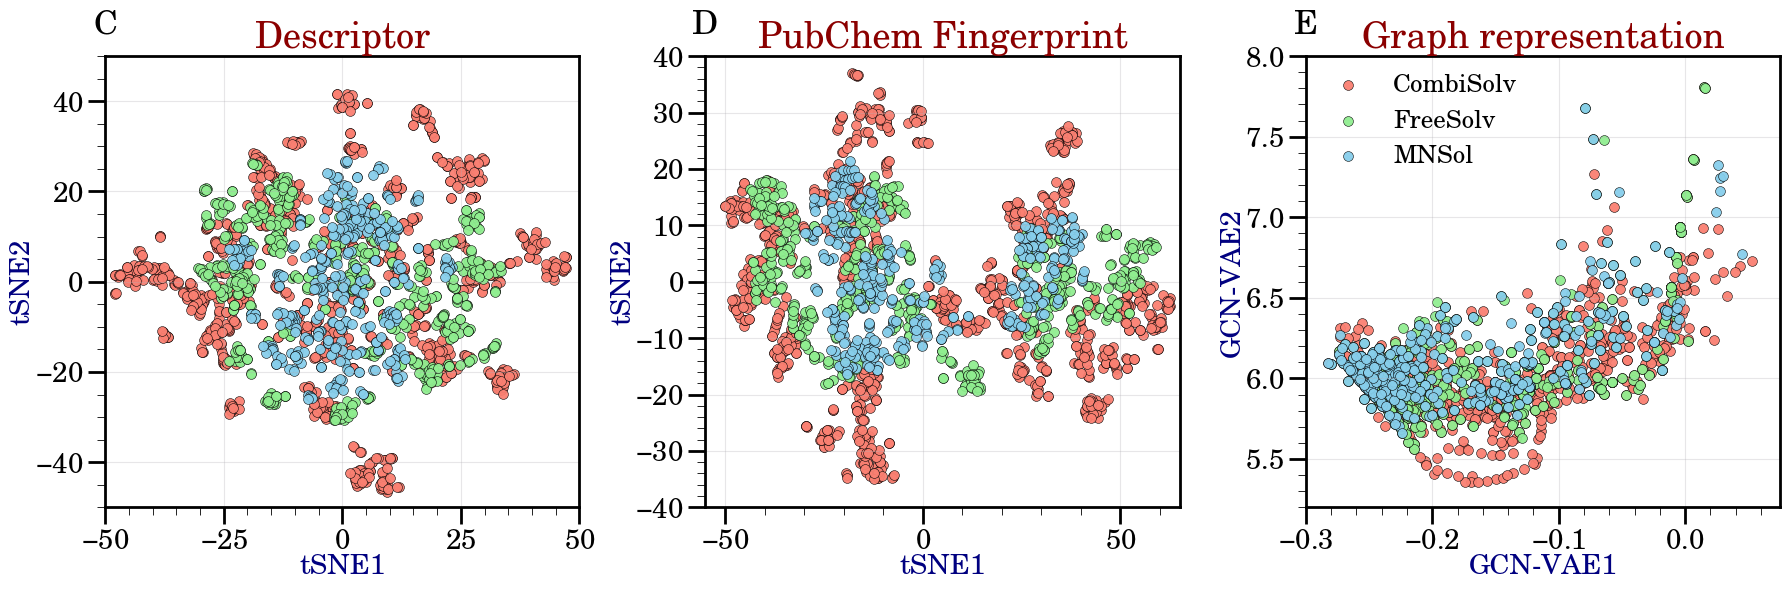

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# TSNE_Descriptor
axes[0].scatter(combisolv_2d_tsne[:, 0], combisolv_2d_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label="CombiSolv")
axes[0].scatter(freesol_2d_tsne[:, 0], freesol_2d_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label="FreeSolv")
axes[0].scatter(mnsol_2d_tsne[:, 0], mnsol_2d_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label="MNSol")
axes[0].set_xlim(-50, 50)
axes[0].set_ylim(-50, 50)
axes[0].set_title('Descriptor', fontsize=26, loc="center", color="darkred")
axes[0].set_xlabel('tSNE1', fontsize=20, color="navy")
axes[0].set_ylabel('tSNE2', fontsize=20, color="navy")
axes[0].grid(alpha=0.3)
axes[0].annotate('C', xy=(0.0, 1.05), xycoords='axes fraction', fontsize=24, fontweight='normal', ha='center')

# TSNE_Fingerprints
axes[1].scatter(csol_pubchem_tsne[:, 0], csol_pubchem_tsne[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label="CombiSolv")
axes[1].scatter(fsol_pubchem_tsne[:, 0], fsol_pubchem_tsne[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label="FreeSolv")
axes[1].scatter(mnsol_pubchem_tsne[:, 0], mnsol_pubchem_tsne[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label="MNSol")
axes[1].set_xlim(-55, 65)
axes[1].set_ylim(-40, 40)
axes[1].set_title('PubChem Fingerprint', fontsize=26, loc="center", color="darkred")
axes[1].set_xlabel('tSNE1', fontsize=20, color="navy")
axes[1].set_ylabel('tSNE2', fontsize=20, color="navy")
axes[1].grid(alpha=0.3)
axes[1].annotate('D', xy=(0.0, 1.05), xycoords='axes fraction', fontsize=24, fontweight='normal', ha='center')

# t-SNE plot
axes[2].scatter(csol_gncvae[:, 0], csol_gncvae[:, 1], c='salmon',
                alpha=0.95, edgecolor='black', s=50, label="CombiSolv")
axes[2].scatter(fsol_gncvae[:, 0], fsol_gncvae[:, 1], c='lightgreen',
                alpha=0.95, edgecolor='black', s=50, label="FreeSolv")
axes[2].scatter(mnsol_gncvae[:, 0], mnsol_gncvae[:, 1], c='skyblue',
                alpha=0.95, edgecolor='black', s=50, label="MNSol")
axes[2].set_xlim(-0.3, 0.075)
axes[2].set_ylim(5.2, 8.0)
axes[2].set_title('Graph representation', fontsize=26, loc="center", color="darkred")
axes[2].set_xlabel('GCN-VAE1', fontsize=20, color="navy")
axes[2].set_ylabel('GCN-VAE2', fontsize=20, color="navy")
axes[2].grid(alpha=0.3)
axes[2].legend(loc="upper left", fontsize=18)
axes[2].annotate('E', xy=(0.0, 1.05), xycoords='axes fraction', fontsize=24, fontweight='normal', ha='center')

plt.tight_layout()
plt.savefig('comp_dimensionality.png', dpi=120)
plt.show()